# Test ResNet50 Architcture without Augmentation

# Importing Libraries

In [1]:
import os
from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install pandas

In [4]:
!pip install matplotlib

In [5]:
!pip install sklearn

In [6]:
!pip install scikit-learn

In [7]:
!pip install pillow

In [8]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

# Designing a Convolution Neural Network (CNN): 

In [9]:
import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=1, num_classes=3):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def test():
    BATCH_SIZE = 32
    device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
    net = ResNet50(img_channel=1, num_classes=3).to(device)
    y = net(torch.randn(BATCH_SIZE, 1, 224, 224)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 3])
    print(y.size())

In [10]:
model = ResNet50()
print(model)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [11]:
model.load_state_dict(torch.load(r"C:\Users\HP\Desktop\Model\ResNet50\ResNet50_Without_Aug\ResNet50.pth", map_location={'cuda:0': 'cpu'}))

model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [12]:
from PIL import Image

In [13]:
def make_prediciton(image_path):
    image = Image.open(image_path).convert("L")
    pretrained_size = 224
    pretrained_means = [0.5]
    pretrained_stds = [0.5]

    train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5)),
            ])
        
    image = train_transforms(image)    
    image = image.reshape(1, 1, 224, 224)
    predict = model(image)
    softmax = nn.Softmax(dim=1)
    predict = softmax(predict)
    probability , prediction = torch.max(predict, dim = 1)
    #converting torch tensor into numpy array
    probability = probability.detach().numpy()[0]
    prediction = prediction.detach().numpy()[0]
    
    return probability, prediction

In [14]:
# make_prediciton(test_dataset[0][0])

In [14]:
make_prediciton(r"C:\Users\HP\Desktop\Model\DATASET\Testing\malignant\malignant (43).png")

(0.9966785, 1)

In [15]:
make_prediciton(r"C:\Users\HP\Desktop\Model\DATASET\Testing\benign\benign (1).png")

(0.99690187, 0)

In [16]:
make_prediciton(r"C:\Users\HP\Desktop\Model\DATASET\Testing\normal\normal (1).png")

(0.99977773, 2)

In [17]:
# Hyper parameters
epochs = 30
num_classes = 3
batch_size = 32
learning_rate = 0.001


In [18]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])


valid_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)),
                       ])

In [20]:
test_dataset = torchvision.datasets.ImageFolder(root= r"C:\Users\HP\Desktop\Model\DATASET\Testing", transform = test_transforms)
# test_dataset = torchvision.datasets.ImageFolder(root= r"C:\Users\HP\Desktop\Model\DATASET", transform = test_transforms)

In [21]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 155
    Root location: C:\Users\HP\Desktop\Model\DATASET\Testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [22]:
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

In [23]:
from tqdm import tqdm

In [24]:
test_dataset[100]

(tensor([[[-0.9529, -0.9137, -0.9216,  ..., -0.6392, -0.9608, -0.9843],
          [-0.9451, -0.9216, -0.9059,  ..., -0.5922, -0.9059, -0.9922],
          [-0.9608, -0.9373, -0.9373,  ..., -0.5922, -0.7882, -0.9765],
          ...,
          [-0.9451, -0.9373, -0.9294,  ..., -0.9137, -0.9137, -0.9059],
          [-0.9373, -0.9451, -0.9451,  ..., -0.8980, -0.9137, -0.9373],
          [-0.9294, -0.9373, -0.9373,  ..., -0.8980, -0.9216, -0.9137]]]),
 1)

In [25]:
preds = []
target = []
probabilities = []
individual_prob = []

for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            outputs = nn.Softmax(dim=1)(outputs)
            prob, predicted = torch.max(outputs.data, 1)
            #Tensor from GPU to CPU by converting pytorch numpy to tensor array
            predicted = predicted.cpu().numpy()
            outputs = outputs.cpu().detach().numpy()
            prob = prob.cpu().detach().numpy()
            labels = labels.cpu().numpy()
            preds.append(predicted)
            target.append(labels)
            #Finding probabilies for each probabilities
            probabilities.append(list(outputs))
            individual_prob.append(list(prob))
            
        

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:43<00:00,  8.74s/it]


Converting 2-D into 1-D array

In [26]:
probabilities1 = []
individual_prob1 = []
preds1 = []
target1 = []

for i in probabilities:
  for j in i:
    probabilities1.append(j)

for i in individual_prob:
  for j in i:
    individual_prob1.append(j)
    
for i in preds:
  for j in i:
    preds1.append(j)
    
for i in target:
  for j in i:
    target1.append(j)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [28]:
accuracy_score(target1,preds1)

0.7870967741935484

In [29]:
print(classification_report(target1,preds1))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86        87
           1       0.81      0.62      0.70        42
           2       0.59      0.85      0.70        26

    accuracy                           0.79       155
   macro avg       0.76      0.77      0.75       155
weighted avg       0.80      0.79      0.79       155



In [30]:
confusion_matrix(target1,preds1)

array([[74,  5,  8],
       [ 9, 26,  7],
       [ 3,  1, 22]], dtype=int64)

In [31]:
import matplotlib.pyplot as plt
import numpy
from sklearn .metrics import roc_auc_score, roc_curve
import seaborn as sns


In [32]:
test_dataset.classes

['benign', 'malignant', 'normal']

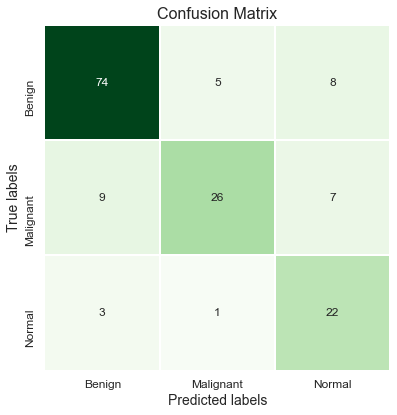

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cm(confusion):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Greens", square=True, 
                cbar=False, annot_kws={"size": 12}, linewidths=0.5)
    plt.xlabel('Predicted labels', fontsize=14)
    plt.ylabel('True labels', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    classes = ['Benign', 'Malignant', 'Normal'] 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + 0.5, classes, fontsize=12)
    plt.yticks(tick_marks + 0.5, classes, fontsize=12)
    plt.tight_layout()
    plt.show()

from sklearn.metrics import confusion_matrix

# Assuming target1 and preds1 are the true labels and predicted labels, respectively
confusion = confusion_matrix(target1, preds1, labels=[0, 1, 2])
plot_cm(confusion)


In [34]:
auc = np.round(roc_auc_score(target1, probabilities1, multi_class = 'ovr'), 3)
print("Auc score for our sample data is {}". format(auc))

Auc score for our sample data is 0.933


In [35]:
probabilities2 = np.array([i for i in probabilities1])

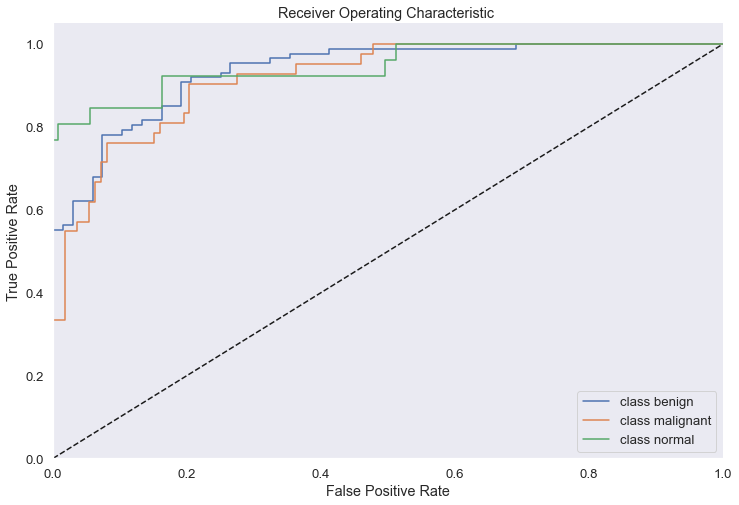

In [36]:
def plot_multiclass_roc(y_score, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    threshold = dict()

    for i in range(n_classes):    
      fpr[i], tpr[i], threshold[i] = roc_curve(target1, probabilities2[:,i], pos_label=i)
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic ')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label = 'class '+ test_dataset.classes[i])
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(probabilities2, target1, n_classes=3, figsize=(12,8))